<a href="https://colab.research.google.com/github/RichardMWarburton/ExploringCUAD/blob/main/Individual%20Clause%20Investigation%20-%20Audit%20Rights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Clause Investigation (Governing Law)

This notebook investigates the governing law annotations and looks to identify similar clauses.

The Governing law clause shuold provide a clear indication of which legal system has oversight for the contract.  As such, the specific answer should be a country or a state (as with countries like America and Austraila)

Most contracts should have this clause, although some may be silent. While a single answer should be expected, there may be some variations to this.

**Example 1 (Single Response):**

"*this letter of authorization will be governed by and construed in accordance with the laws of california excluding its conflict of laws provisions and be subject to the nonexclusive jurisdiction of the california courts*"

**Example 2 (Multiple Responses):**

"*the validity interpretation and performance of this agreement shall be controlled by and construed under the laws of the state of newyork united states of america as if performed wholly within the state and without giving effect to the principles of conflicts of law and the state and federal courts of california shall have jurisdiction over any claim arising under this agreement*"

**The Challenge:**

How do we best vectorise the annotations to draw out the differences in state/country and multiple governing laws





## The Data

CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review

https://arxiv.org/abs/2103.06268

This code is an adaptation of the scrape.py file avaliable on the github repository for CUAD.  It has been adapted to run in Jypter notebooks and allow us to step throght the coding line by line.`

## 1: Import Packages & Define Useful Functions

In [ ]:
from zipfile import ZipFile
import json
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import re
from random import sample, choice
import numpy as np
import pandas as pd
import re
import string
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import AgglomerativeClustering

In [ ]:
def extract_zip(pth,data_pth = None):
    """Function to extract contents of a zip file to a specified location (wd if data_pth not passed)"""
    with ZipFile(pth, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(data_pth)

## 2: Download repository and extract data

In [ ]:
#Download CUAD git repository
if not os.path.exists('main.zip'):
  !wget --no-check-certificate https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
  !unzip -q main.zip

#If it has not already been extracted, extract the contents of data.zip
if not os.path.exists('cuad-main/data'):
  os.makedirs('cuad-main/data')

if not os.path.exists('cuad-main/data/CUADv1.json'):
  extract_zip('cuad-main/data.zip','cuad-main/data/')

#Download a manualy curated set of labels for the full CUAD data. 
if not os.path.exists('labels3.txt'):
  !wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt

--2021-07-16 10:45:29--  https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/TheAtticusProject/cuad/zip/refs/heads/main [following]
--2021-07-16 10:45:29--  https://codeload.github.com/TheAtticusProject/cuad/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ]  17.77M  23.4MB/s    in 0.8s    

2021-07-16 10:45:30 (23.4 MB/s) - ‘main.zip’ saved [18631176]

--2021-07-16 10:45:31--  https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt
Resolving raw.githubuserconten

In [ ]:
#Load CUADv1 JSON to data
with open('cuad-main/data/CUADv1.json','r') as infile:
    for line in infile:
        contract_data = json.loads(line)

### 2.1: Read in Label Data & Generate Look Up Dictionary

In [ ]:
#Initate storage for labels look up (LU)
labels_LU = {}

#Read in labels data
with open('labels3.txt','r',encoding ='UTF-8') as infile:
  for line in infile:
    #Remove trailing special characters and split on tab
    data = line.strip().split(sep='\t')
    #Add name and label to labels_LU dictionary
    labels_LU[data[0]] = data[1]

The look up returns one error, most likely due to the accented E and a disparity of encoding.  This will be forced to 'Marketing Agreement' manually for now (EITHER SORT OR PROVIDE EXAMPLE)

### 2.2: Extract Raw Contract Data

In [ ]:
#ser reg ex expression for characters to remove from contract contest
spec_chars = '\\n|\\t|\\t'

#Set number of contracts in data
num_contracts = len(contract_data['data'])

#Initate dictionary to store raw contract data
raw_contracts = defaultdict(list)

#for each contract
for i in range(num_contracts):
  #Append the title, contract text and character length of text to the raw_contracts dictionary
  raw_contracts['contract title'].append(contract_data['data'][i]['title'])
  raw_contracts['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' ) #<- manual error trap applied here (see below)
  
  #Parse raw text and process to remove breaks
  raw_text = contract_data['data'][i]['paragraphs'][0]['context']
  clean_text = re.sub(spec_chars,'',raw_text)

  #Split clean text in to sentances and tokens
  sentance_text = clean_text.split(sep = '. ')
  token_text = clean_text.split(sep = ' ')

  #Append text to the respective key in the raw_contracts dictionary
  raw_contracts['raw text'].append(raw_text)
  raw_contracts['clean text'].append(clean_text)
  raw_contracts['sentance text'].append(sentance_text)
  raw_contracts['token text'].append(token_text)
  
  #Add character, sentance and token counts to raw_contracts dictionary
  raw_contracts['character count'].append(len(raw_text))
  raw_contracts['sentance count'].append(len(sentance_text))
  raw_contracts['token count'].append(len(token_text))


In [ ]:
#Sanity check value lists for each key ahve the correct length (510)
for key in raw_contracts:
  print(key,len(raw_contracts[key]))

contract title 510
label 510
raw text 510
clean text 510
sentance text 510
token text 510
character count 510
sentance count 510
token count 510


### 2.3: Extract Clause Specific Data

In [ ]:
#Define the number of clauses
num_clauses = 41

#initate dictioanry to store caluse data
clause_data = defaultdict(list)

#For each contract
for i in range(num_contracts):
  #for each clause
  for j in range(num_clauses):
    #for each found clause annotation
    for k in range(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'])): 
      #Add the contract title
      clause_data['contract title'].append(contract_data['data'][i]['title'])
      clause_data['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' )  #<- manual error trap applied here
      clause_data['clause'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['id'].split(sep='__')[1])
      clause_data['annotation'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text'])
      clause_data['annotation start'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['answer_start'])
      clause_data['annotation length'].append(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text']))


In [ ]:
#Sanity check value lists for each key ahve the correct length (13823)
for key in clause_data:
  print(key,len(clause_data[key]))

contract title 13823
label 13823
clause 13823
annotation 13823
annotation start 13823
annotation length 13823


In [ ]:
np.unique(clause_data['clause'])

array(['Affiliate License-Licensee', 'Affiliate License-Licensor',
       'Agreement Date', 'Anti-Assignment', 'Audit Rights',
       'Cap On Liability', 'Change Of Control',
       'Competitive Restriction Exception', 'Covenant Not To Sue',
       'Document Name', 'Effective Date', 'Exclusivity',
       'Expiration Date', 'Governing Law', 'Insurance',
       'Ip Ownership Assignment', 'Irrevocable Or Perpetual License',
       'Joint Ip Ownership', 'License Grant', 'Liquidated Damages',
       'Minimum Commitment', 'Most Favored Nation',
       'No-Solicit Of Customers', 'No-Solicit Of Employees',
       'Non-Compete', 'Non-Disparagement', 'Non-Transferable License',
       'Notice Period To Terminate Renewal', 'Parties',
       'Post-Termination Services', 'Price Restrictions', 'Renewal Term',
       'Revenue/Profit Sharing', 'Rofr/Rofo/Rofn', 'Source Code Escrow',
       'Termination For Convenience', 'Third Party Beneficiary',
       'Uncapped Liability', 'Unlimited/All-You-Can-Eat

## 3: Cleaning data and extracting a single clause

In [ ]:
#Initate dataframe of all clause data
clause_df = pd.DataFrame(clause_data)

#Convert to lower case
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.lower())

#Remove any formating characters or multiple spaces and replace with a single space
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('\\t|\\r|\\n|[^\S]{2,}',' ',x))

#Remove punctuation from the string
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
#Define clause of interest
clause_of_interest = 'Governing Law'

#Limit df to clause of interest and extract annotations of itnerest
of_interest_data = clause_df[clause_df['clause'] == clause_of_interest]
annotations_of_interest = of_interest_data['annotation'].values

#Identify where there are multiple annotations per contract
titles,counts = np.unique(of_interest_data['contract title'],return_counts =True)
dups = titles[counts >= 2]

#Output Analysis
print('There are {} contracts with \'{}\' annotations'.format(*(titles.shape[0],clause_of_interest)))
print('There are {} contracts with more than one annotation'.format(dups.shape[0]))

There are 437 contracts with 'Governing Law' annotations
There are 25 contracts with more than one annotation


From the above we can see that: 

1.   Contracts may have multiple annotations for the same clause
2.   Not all contracts have an annotation of interest

Provisionally, we will look to concatinate all such annotations for a contract in to one string.  This will then represent all the salient points for the contract and clause in question.

In [ ]:
#output duplicate annotations anc contract titles
dup_df = of_interest_data[of_interest_data['contract title'].isin(dups)][['contract title','annotation']]

#print sample of duplicate annotations
for i in dup_df.index[:8]:
  print(dup_df.loc[i,'contract title'])
  print(repr(dup_df.loc[i,'annotation']))
  #print(dup_df.loc[i,'annotation'].split(sep=' '))
  print('\n')

ChinaRealEstateInformationCorp_20090929_F-1_EX-10.32_4771615_EX-10.32_Content License Agreement
'this termination agreement shall be governed by the laws of the prc without regard to conflicts of law principles'


ChinaRealEstateInformationCorp_20090929_F-1_EX-10.32_4771615_EX-10.32_Content License Agreement
'this agreement and any dispute or claim arising out of or in connection with it or its subject matter shall be governed by and construed in accordance with the laws of the peoples republic of china without regard to its conflicts of laws rules that would mandate the application of the laws of another jurisdiction'


LOYALTYPOINTINC_11_16_2004-EX-10.2-RESELLER AGREEMENT
'this agreement shall be subject to and governed by the laws of the state of missouri usa'


LOYALTYPOINTINC_11_16_2004-EX-10.2-RESELLER AGREEMENT
'this agreement shall be deemed to have been made and executed in the state of missouri and any dispute arising thereunder shall be resolved in accordance with the laws o

**THE ABOVE COULD BE DISPLAYED BETTER**

In [ ]:
#Initate memory for annotations within contracts
combined_annotations_list = defaultdict(list)
combined_annotations_string = {}

#For each annotation of interest found in the contract, 
#append annotation to a default dict list with contract as key
for i in of_interest_data.index:
  name = of_interest_data.loc[i,['contract title']].values[0]
  annotation = of_interest_data.loc[i,['annotation']].values[0]
  combined_annotations_list[name].append(annotation)

#Produce a singel string of all annotations found in specific contracts
for key in combined_annotations_list.keys():
  combined_annotations_string[key] = ' '.join(combined_annotations_list[key])

In [ ]:
#Build array of contract names and concatenated annotations
contracts = np.array(list(combined_annotations_string.keys()))
combined_annotations = np.array(list(combined_annotations_string.values()))

## Section 4: Vectorizing 'Governing Law' Annotations & Visualising Output

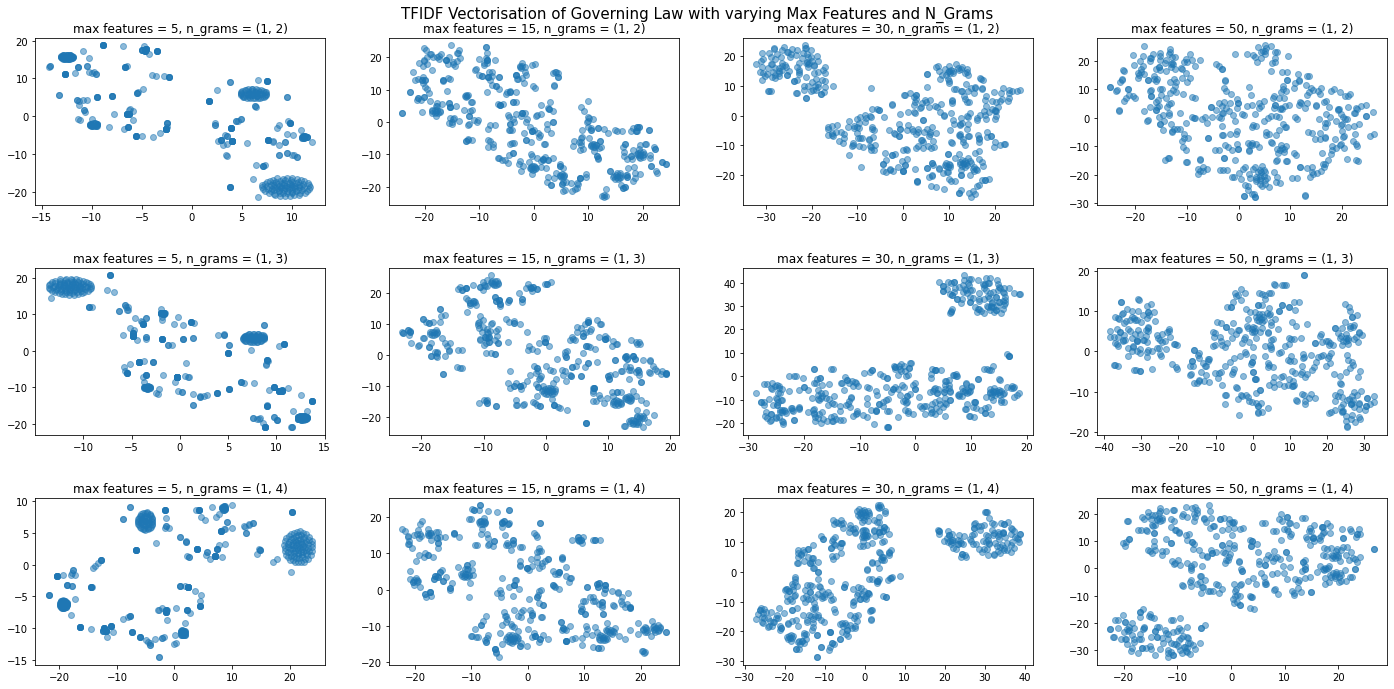

In [ ]:
#Define max feature and n_gram ranges
max_features = [5,15,30,50]
n_grams = [(1,2),(1,3),(1,4)]

#Initate plot
fig, axs = plt.subplots(len(n_grams),len(max_features), figsize = (20,10))

#For each pair of max_features and n_grams
for i in range(len(max_features)):
  for j in range(len(n_grams)):

    #TFIDF vectorize the annotation
    vectorizer = TfidfVectorizer(ngram_range = n_grams[j],stop_words ='english',max_features=max_features[i])
    X = vectorizer.fit_transform(combined_annotations).toarray()  

    #Reduce dimension wiht TSNE to 2D
    X_tsne = TSNE(n_components=2).fit_transform(X)
    x = X_tsne[:,0]
    y = X_tsne[:,1]

    #Plot respective parameters
    axs[j,i].scatter(x, y, alpha = 0.5)
    axs[j,i].set_title('max features = {}, n_grams = {}'.format(*(max_features[i],n_grams[j])))

#Format plot
plt.tight_layout(pad=3.0)
plt.suptitle('TFIDF Vectorisation of {} with varying Max Features and N_Grams\n\n'.format(clause_of_interest),size = 15)
plt.show()

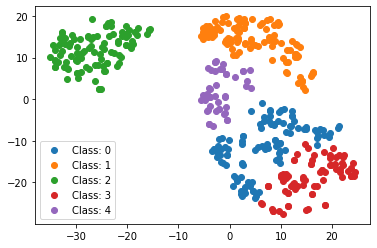

In [ ]:
selected_max_features = 30
selected_n_gram = (1,4)

vectorizer = TfidfVectorizer(ngram_range = selected_n_gram,stop_words ='english',max_features=selected_max_features)
X = vectorizer.fit_transform(combined_annotations).toarray()  

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(X)

#Fit agglomerative clister model with two clusters to split groups
cluster = AgglomerativeClustering(n_clusters=5).fit(X_tsne)

x = X_tsne[:,0]
y = X_tsne[:,1]
labels = cluster.labels_

for i in np.unique(labels):
  idx = labels == i
  plt.scatter(x[idx],y[idx],label = 'Class: {}'.format(str(i)))

plt.legend()
plt.show()

In [ ]:
#Define number of random samples to return
n=5

#For each clustered class
for i in np.unique(labels):
  #Initate counters
  ny_count = 0
  new_count = 0

  #identify class indicies
  idx = labels == i

  #Obtain class data via indicies
  cluster_data = combined_annotations[idx]

  #For each annotation in the class data
  for annotation in cluster_data:
    
    #Count if 'New York' is in the annotation
    if 'new york' in annotation:
      ny_count += 1
    
    #Count if 'New' is in the annotations
    if 'new' in annotation:
      new_count += 1

  #Return n random annotaitons from cluster data
  rnd_samples = np.random.choice(cluster_data,n)
  
  #Outout random samples and summary data
  print('*'*75+'\n')
  print('Class Random Samples:',str(i),'\n')
  for smp in rnd_samples:
    print(smp)
  print('\nClass Analysis:',str(i))
  print('\nThere are {} instances where \'new\' is in the annotation ({:.2%})'.format(*(new_count,new_count/len(cluster_data))))
  print('There are {} instances where \'new york\' is in the annotation ({:.2%})\n'.format(*(ny_count,ny_count/len(cluster_data))))
print('*'*75) 

***************************************************************************

Class Random Samples: 0 

this agreement takes effect upon its acceptance and execution by airsopure in the state of texas and shall be interpreted and construed under the laws of the state of texas
the validity interpretation and performance of this agreement and any dispute connected with this agreement will be governed by and determined in accordance with the statutory regulatory and decisional law of the state of delaware exclusive of such states choice of laws or conflicts of laws rules and to the extent applicable the federal statutory regulatory and decisional law of the united states
this agreement shall be governed by and its provisions enforced in accordance with the laws of california without regard to its principles of conflicts of laws
this agreement and any action related thereto shall be governed controlled interpreted and defined by and under the laws of the state of california and the united s

## Section 5: Removal of Stop Works and 'New' from annotations

In [ ]:
"""NOTE: Variables Recycled from Section 4"""

#Remove 'new' from the annotation

stop_words = 'this agreement shall be governed by the laws of the state of'.split(sep=' ')
stop_words += ['new']

clause_df['reduced annotation'] = clause_df['annotation'].apply(lambda x : ' '.join([word for word in x.split() if word not in stop_words]))

#Define clause of interest
clause_of_interest = 'Governing Law'

#Limit df to clause of interest and extract annotations of itnerest
of_interest_data = clause_df[clause_df['clause'] == clause_of_interest]
annotations_of_interest = of_interest_data['reduced annotation'].values

#Initate memory for annotations within contracts
combined_annotations_list = defaultdict(list)
combined_annotations_string = {}

#For each annotation of interest found in the contract, 
#append annotation to a default dict list with contract as key
for i in of_interest_data.index:
  name = of_interest_data.loc[i,['contract title']].values[0]
  annotation = of_interest_data.loc[i,['reduced annotation']].values[0]
  combined_annotations_list[name].append(annotation)

#Produce a single string of all annotations found in specific contracts
for key in combined_annotations_list.keys():
  combined_annotations_string[key] = ' '.join(combined_annotations_list[key])

#Build array of contract names and concatenated annotations
contracts = np.array(list(combined_annotations_string.keys()))
combined_annotations = np.array(list(combined_annotations_string.values()))

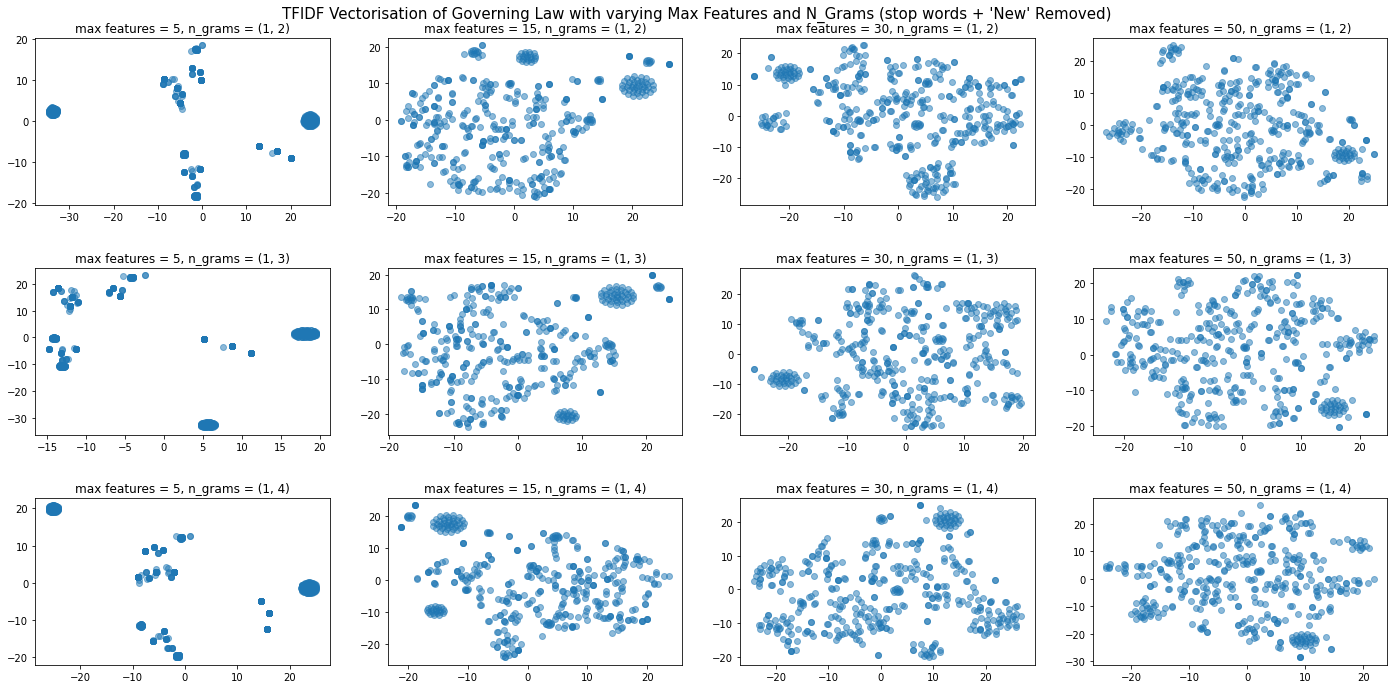

In [ ]:
#Define max feature and n_gram ranges
max_features = [5,15,30,50]
n_grams = [(1,2),(1,3),(1,4)]

#Initate plot
fig, axs = plt.subplots(len(n_grams),len(max_features), figsize = (20,10))

#For each pair of max_features and n_grams
for i in range(len(max_features)):
  for j in range(len(n_grams)):

    #TFIDF vectorize the annotation
    vectorizer = TfidfVectorizer(ngram_range = n_grams[j],stop_words ='english',max_features=max_features[i])
    X = vectorizer.fit_transform(combined_annotations).toarray()  

    #Reduce dimension wiht TSNE to 2D
    X_tsne = TSNE(n_components=2).fit_transform(X)
    x = X_tsne[:,0]
    y = X_tsne[:,1]

    #Plot respective parameters
    axs[j,i].scatter(x, y, alpha = 0.5)
    axs[j,i].set_title('max features = {}, n_grams = {}'.format(*(max_features[i],n_grams[j])))

#Format plot
plt.tight_layout(pad=3.0)
plt.suptitle('TFIDF Vectorisation of {} with varying Max Features and N_Grams (stop words + \'New\' Removed)\n\n'.format(clause_of_interest),size = 15)
plt.show()

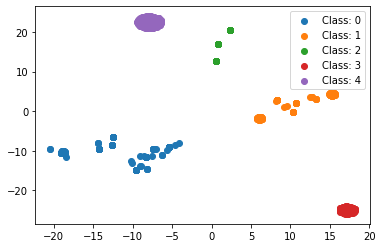

In [ ]:
selected_max_features = 5
selected_n_gram = (1,4)

vectorizer = TfidfVectorizer(ngram_range = selected_n_gram,stop_words ='english',max_features=selected_max_features)
X = vectorizer.fit_transform(combined_annotations).toarray()  

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(X)

#Fit agglomerative clister model with two clusters to split groups
cluster = AgglomerativeClustering(n_clusters=5).fit(X_tsne)

x = X_tsne[:,0]
y = X_tsne[:,1]
labels = cluster.labels_

for i in np.unique(labels):
  idx = labels == i
  plt.scatter(x[idx],y[idx],label = 'Class: {}'.format(str(i)))

plt.legend()
plt.show()

In [ ]:
#Define number of random samples to return
n=5

#For each clustered class
for i in np.unique(labels):
  #Initate counters
  ny_count = 0
  new_count = 0

  #identify class indicies
  idx = labels == i

  #Obtain class data via indicies
  cluster_data = combined_annotations[idx]

  #For each annotation in the class data
  for annotation in cluster_data:
    
    #Count if 'New York' is in the annotation
    if 'new york' in annotation:
      ny_count += 1
    
    #Count if 'New' is in the annotations
    if 'new' in annotation:
      new_count += 1

  #Return n random annotaitons from cluster data
  rnd_samples = np.random.choice(cluster_data,n)
  
  #Outout random samples and summary data
  print('*'*75+'\n')
  print('Class Random Samples:',str(i),'\n')
  for smp in rnd_samples:
    print(smp)
print('\n'+'*'*75) 

***************************************************************************

Class Random Samples: 0 

and all actions whether in contract or tort that may based upon arise out or relate to or negotiation execution or performance hereof or thereof and construed in accordance with law delaware without regard to any or principles thereof that would result in application any other jurisdiction
will delaware without regard to its conflicts law principles
construed and enforced in accordance with delaware without regard to choice law principles that would require application any other jurisdiction
in all respects including validity interpretation and effect and construed in accordance with delaware executed and to performed wholly within delaware without giving effect to choice law or conflict law principles thereof or any other jurisdiction to extent that such principles would require or permit application another jurisdiction
construed in accordance with york applicable to contracts forme

# Section 6: Key word Parsing

In [ ]:
#Get key word files
!wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/countries.txt
!wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/us_states.txt

--2021-07-16 10:46:50--  https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/countries.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1842 (1.8K) [text/plain]
Saving to: ‘countries.txt’

countries.txt       100%[===================>]   1.80K  --.-KB/s    in 0s      

2021-07-16 10:46:50 (29.4 MB/s) - ‘countries.txt’ saved [1842/1842]

--2021-07-16 10:46:50--  https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/us_states.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 520 [text/plain]


In [ ]:
#Build list of key_words to identify
key_words = ['newyork','newjersey','hongkong', 'england', 'englandandwales']

with open('countries.txt','r') as infile:
  for line in infile:
    key_words.append(line.strip().lower())

with open('us_states.txt','r') as infile:
  for line in infile:
    key_words.append(line.strip().lower())

Rebuild the base data to analyise and apply specific cleaning required

In [ ]:
#Initate dataframe of all clause data
clause_df = pd.DataFrame(clause_data)

#Convert to lower case
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.lower())

#Remove any formating characters or multiple spaces and replace with a single space
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('\\t|\\r|\\n|[^\S]{2,}',' ',x))

#Remove punctuation from the string
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Reduce locations with two word (or more) in names to a single token
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('new york','newyork',x))
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('hong kong','hongkong',x))
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('new jersey','newjersey',x))
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('england and wales','englandandwales',x))

In [ ]:
#Define clause of interest
clause_of_interest = 'Governing Law'

#Limit df to clause of interest and extract annotations of itnerest
of_interest_data = clause_df[clause_df['clause'] == clause_of_interest]
annotations_of_interest = of_interest_data['annotation'].values

#Identify where there are multiple annotations per contract
titles,counts = np.unique(of_interest_data['contract title'],return_counts =True)
dups = titles[counts >= 2]

#Output Analysis
print('There are {} contracts with \'{}\' annotations'.format(*(titles.shape[0],clause_of_interest)))
print('There are {} contracts with more than one annotation'.format(dups.shape[0]))

There are 437 contracts with 'Governing Law' annotations
There are 25 contracts with more than one annotation


In [ ]:
#Initate memory for annotations within contracts
combined_annotations_list = defaultdict(list)
combined_annotations_string = {}

#For each annotation of interest found in the contract, 
#append annotation to a default dict list with contract as key
for i in of_interest_data.index:
  name = of_interest_data.loc[i,['contract title']].values[0]
  annotation = of_interest_data.loc[i,['annotation']].values[0]
  combined_annotations_list[name].append(annotation)

#Produce a singel string of all annotations found in specific contracts
for key in combined_annotations_list.keys():
  combined_annotations_string[key] = ' '.join(combined_annotations_list[key])

In [ ]:
#Rebuild the combined annotations pd array
combined_annotations = np.array(list(combined_annotations_string.values()))

In [ ]:
#Initate memory for new annotation tokens
new_annotations = []

#For each annotation
for annotation in list(combined_annotations_string.values()):
  ##Initate memory for matched words in annotation
  matched_key_words = []
  #for each word (token) in the annotation
  for word in annotation.split(sep = ' '):
    #If the word is in key words (i.e. is a country) add to matched_key_words
    if word in key_words:
      matched_key_words.append(word)

  #If no match is found, add 'TBC' as a holding response
  if len(matched_key_words) == 0:
    matched_key_words.append('TBC')
  
  #Add the specific annotation key words to the new_annotations list
  new_annotations.append(' '.join(matched_key_words))


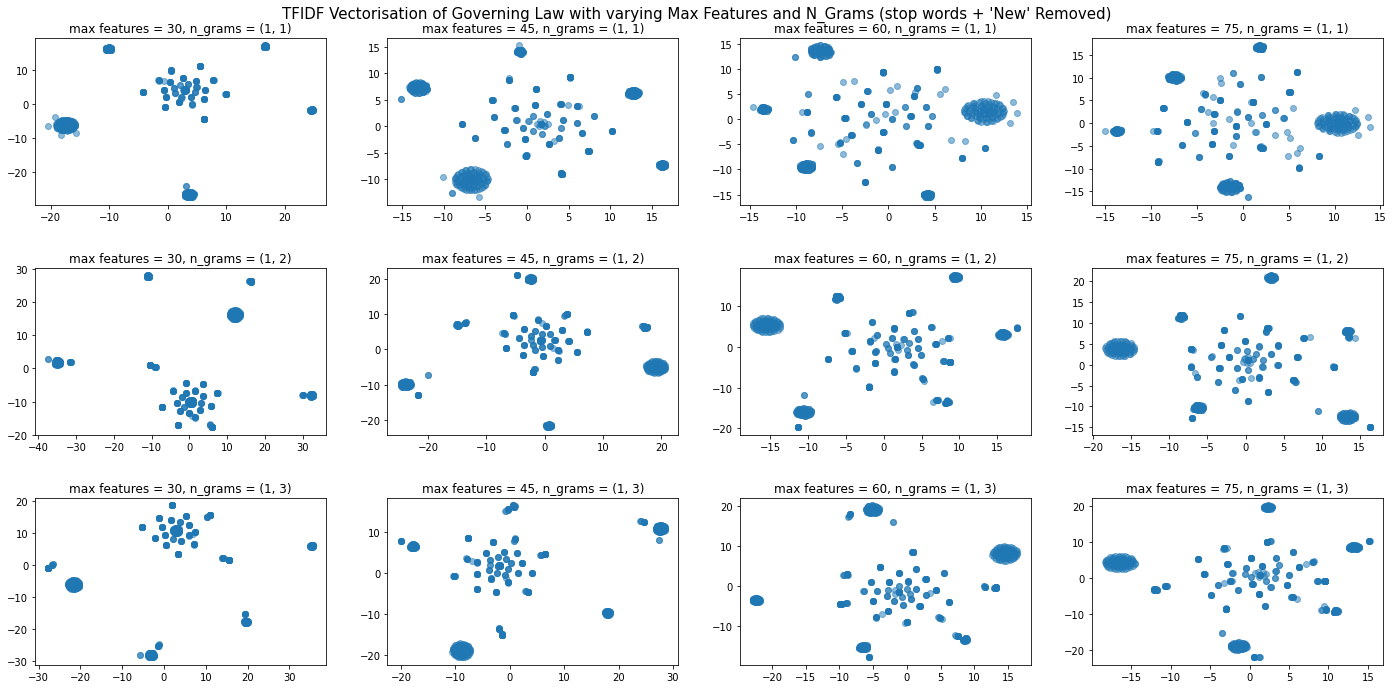

In [ ]:
#Define max feature and n_gram ranges
max_features = [30,45,60,75]
n_grams = [(1,1),(1,2),(1,3)]

#Initate plot
fig, axs = plt.subplots(len(n_grams),len(max_features), figsize = (20,10))

#For each pair of max_features and n_grams
for i in range(len(max_features)):
  for j in range(len(n_grams)):

    #TFIDF vectorize the annotation
    vectorizer = TfidfVectorizer(ngram_range = n_grams[j],stop_words ='english',max_features=max_features[i])
    X = vectorizer.fit_transform(new_annotations).toarray()  

    #Reduce dimension wiht TSNE to 2D
    X_tsne = TSNE(n_components=2).fit_transform(X)
    x = X_tsne[:,0]
    y = X_tsne[:,1]

    #Plot respective parameters
    axs[j,i].scatter(x, y, alpha = 0.5)
    axs[j,i].set_title('max features = {}, n_grams = {}'.format(*(max_features[i],n_grams[j])))

#Format plot
plt.tight_layout(pad=3.0)
plt.suptitle('TFIDF Vectorisation of {} with varying Max Features and N_Grams (stop words + \'New\' Removed)\n\n'.format(clause_of_interest),size = 15)
plt.show()

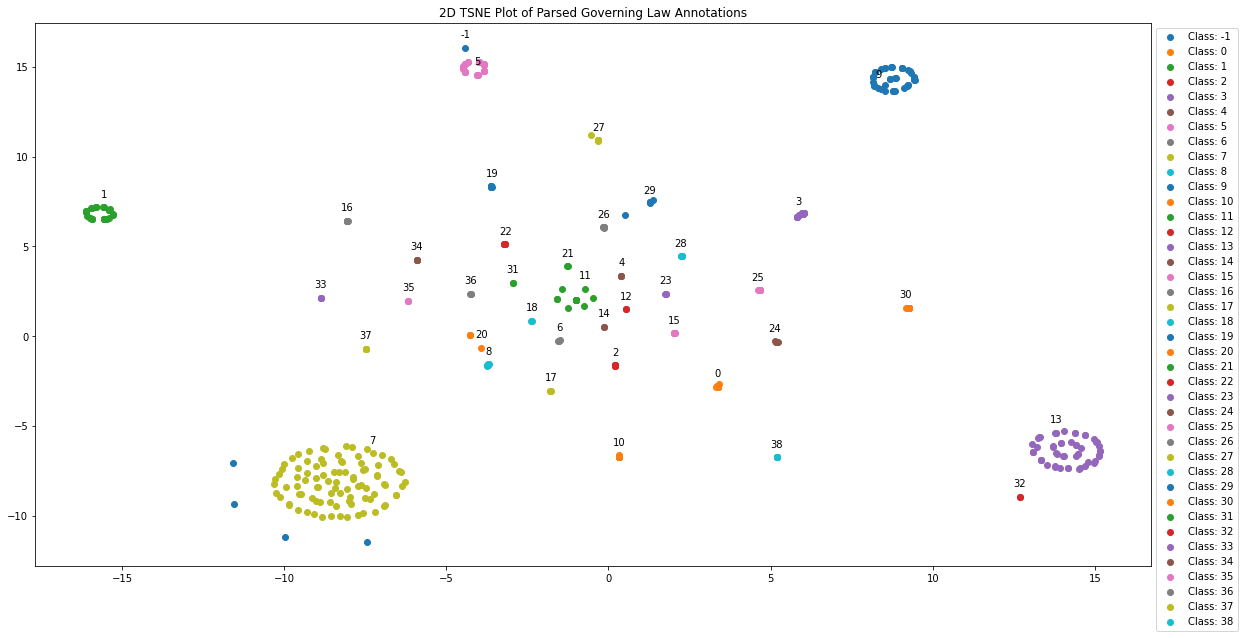

In [ ]:
#Select chosen parameters
selected_max_features = 45
selected_n_gram = (1,1)

#Vectorize with given parameters
vectorizer = TfidfVectorizer(ngram_range = selected_n_gram,stop_words ='english',max_features=selected_max_features)
X = vectorizer.fit_transform(new_annotations).toarray()  

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(X)

#Fit agglomerative clister model with two clusters to split groups
cluster = DBSCAN(eps=0.8, min_samples=2).fit(X_tsne)

#Extract key data
x = X_tsne[:,0]
y = X_tsne[:,1]
labels = cluster.labels_

#Plot in 2D
plt.figure(figsize=(20,10))

#For each label
for i in np.unique(labels):
  #Identify specific points and plot/label
  idx = labels == i
  plt.scatter(x[idx],y[idx],label = 'Class: {}'.format(str(i)))
plt.legend(bbox_to_anchor = (1,1))


"""
The following looks to lable one point from each class
This helps with visualisation and understanding
"""

#NOTE TO SELF:  IS THERE A NEATER WAY TO DO THIS???

#Initate index counter
ii=0

#Initate flag to say if clust has been labled (False to start with)
bool_flag = {}
for lab in labels:
  bool_flag[lab] = False

#Lable each point, if not labeld previously
for xs,ys in zip(x,y):
    #Identify class label
    label = labels[ii]

    #If not previousl labled on plot
    if not bool_flag[label]:
      plt.annotate(label, # this is the text
                  (xs,ys), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center
      
      #Flag label as having been labeld on plot
      bool_flag[label] = True
    #Increment index
    ii+=1

plt.title('2D TSNE Plot of Parsed Governing Law Annotations')
plt.show()


### Section 6.1 New annotation output by class

In [ ]:
#Define number of random samples to return
n=5

#For each clustered class
for i in np.unique(labels):
  #Initate counters
  ny_count = 0
  new_count = 0

  #identify class indicies
  idx = labels == i

  #Obtain class data via indicies
  cluster_data = np.array(new_annotations)[idx]

  #For each annotation in the class data
  for annotation in cluster_data:
    
    #Count if 'New York' is in the annotation
    if 'new york' in annotation:
      ny_count += 1
    
    #Count if 'New' is in the annotations
    if 'new' in annotation:
      new_count += 1

  #Return n random annotaitons from cluster data
  rnd_samples = np.random.choice(cluster_data,n)
  
  #Outout random samples and summary data
  print('*'*75+'\n')
  print('Class Random Samples:',str(i),'\n')
  for smp in rnd_samples:
    print(smp)
print('\n'+'*'*75) 

***************************************************************************

Class Random Samples: -1 

newyork newyork
englandandwales england
newyork
newyork
newyork
***************************************************************************

Class Random Samples: 0 

illinois
illinois
illinois
delaware illinois
illinois
***************************************************************************

Class Random Samples: 1 

TBC
TBC
TBC
TBC
TBC
***************************************************************************

Class Random Samples: 2 

china china
china
china
china
china
***************************************************************************

Class Random Samples: 3 

florida
florida
florida
florida florida
florida
***************************************************************************

Class Random Samples: 4 

kansas
kansas
kansas
kansas
kansas
***************************************************************************

Class Random Samples: 5 

texas
texas
texas tex

### Section 6.2: Full annotation output by class

In [ ]:
#Define number of random samples to return
n=5

#For each clustered class
for i in np.unique(labels):
  #Initate counters
  ny_count = 0
  new_count = 0

  #identify class indicies
  idx = labels == i

  #Obtain class data via indicies
  cluster_data = combined_annotations[idx]

  #For each annotation in the class data
  for annotation in cluster_data:
    
    #Count if 'New York' is in the annotation
    if 'new york' in annotation:
      ny_count += 1
    
    #Count if 'New' is in the annotations
    if 'new' in annotation:
      new_count += 1

  #Return n random annotaitons from cluster data
  rnd_samples = np.random.choice(cluster_data,n)
  
  #Outout random samples and summary data
  print('*'*75+'\n')
  print('Class Random Samples:',str(i),'\n')
  for smp in rnd_samples:
    print(smp)
print('\n'+'*'*75) 

***************************************************************************

Class Random Samples: -1 

this agreement will be construed under and in accordance with and governed in all respects by the laws of the state of newyork without regard to its conflicts of law principles
this agreement between em and buyer shall be governed by the laws of belgium excluding its rules on conflict of laws this agreement shall be governed by singapore law without regard to its conflict of laws principles the parties rights and obligations hereunder shall be construed and enforced under the laws of the state of texas usa without regard to conflict of laws principles incoterms 2010 or any subsequent revision thereof incoterms shall also apply provided however that incoterms shall apply only to the extent specified in the agreement hereof and provided further that in the event of a conflict between incoterms and the laws of the state of texas usa the latter shall govern this agreement shall be govern